In [1]:
# gpu 연동
# 드라이브연동
%cd /content/drive/MyDrive/Colab Notebooks/DeepLearning

/content/drive/MyDrive/Colab Notebooks/DeepLearning


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 목표
  - mlp, cnn 모델을 활용하여 이미지 이진분류 문제를 해결해보자
  - 모델의 성능을 높이기 위한 방법을 알아보자
    - cnn 모델 설정
    - 이미지 증식
    - 전이학습

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
# npz 데이터 불러오기
data = np.load('./data/np_cats_dogs.npz')
data

NpzFile './data/np_cats_dogs.npz' with keys: X_train, X_test, y_train, y_test

In [5]:
# 각변수에 데이터 분리해서 담아주기
X_train = data['X_train']
X_test = data['X_test']
y_train = data['y_train']
y_test= data['y_test']

# 크기확인
print('훈련:',X_train.shape, y_train.shape)
print('테스트:', X_test.shape, y_test.shape)
# cats(0) - 1000, dogs(1) - 1000
# cats(0) - 500, dogs(1) - 500

훈련: (2000, 224, 224, 3) (2000,)
테스트: (1000, 224, 224, 3) (1000,)


#### mlp 모델 생성
  - 1. mlp 기반 모델 생성
    - 뼈대 구축: Sequential
    - 층 쌓기: Dense
  - 2. 모델 학습/평가 방법 설정
    - 이진분류! : binary_crossentropy, adam,accuracy
  - 3. 모델 학습 및 정확도 시각화
  - 4. 모델 예측 및 평가

In [6]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, InputLayer
from tensorflow.keras.callbacks import EarlyStopping # 조기학습 중단
# 5번 정도 기다려도 val_accuracy 성능 개선되지 않으면 학습 중단

In [ ]:
model = Sequential()

# 입력층 내용 정의 Flatten
# model.add(Flatten(input_shape = (행,열,채널의 크기))) # 3차원 > 1차원
model.add(Flatten(input_shape = (224,224,3)))

model.add(InputLayer(input_shape = (224,224,3)))

model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=256, activation='relu'))
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=64, activation='relu'))

model.add(Dense(units=1, activation='sigmoid'))

model.summary()



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 150528)            0         
                                                                 
 input_1 (InputLayer)        multiple                  0         
                                                                 
 dense (Dense)               (None, 64)                9633856   
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dense_2 (Dense)             (None, 256)               33024     
                                                                 
 dense_3 (Dense)             (None, 128)               32896     
                                                                 
 dense_4 (Dense)             (None, 64)               

In [ ]:
model.compile(loss='binary_crossentropy',
        optimizer='Adam',
        metrics='accuracy')

# 조기학습 중단 정의
# 교차검증 정확도 기준으로 5번 정도 기다림 > 성능 개선x > 학습중단
# 모니터: 교차검증 정확도, 기다리는 횟수: 5
f_ea = EarlyStopping(monitor='val_accuracy',
                     patience = 5,
                     verbose =1) # 조기학습 중단 현황 출력/ 0: 출력x

# 학습
# 문제, 답, 검증데이터 분리 validation_split=0.3, 반복횟수: 40,
# 조기학습 중단 연결 callbacks=[f_ea], batch_size = 64
# 학습현황 mlp_his 변수에 담아주기

mlp_his = model.fit(X_train, y_train,
          validation_split = 0.3,
          epochs = 40,
          batch_size=64,
          callbacks=[f_ea])

Epoch 1/40
22/22 [==============================] - 5s 38ms/step - loss: 699.7919 - accuracy: 0.5857 - val_loss: 267.6977 - val_accuracy: 0.0000e+00
Epoch 2/40
22/22 [==============================] - 0s 16ms/step - loss: 47.7586 - accuracy: 0.5657 - val_loss: 84.4337 - val_accuracy: 0.0000e+00
Epoch 3/40
22/22 [==============================] - 0s 21ms/step - loss: 4.1661 - accuracy: 0.7143 - val_loss: 0.7651 - val_accuracy: 0.0000e+00
Epoch 4/40
22/22 [==============================] - 0s 19ms/step - loss: 0.6276 - accuracy: 0.7143 - val_loss: 1.2824 - val_accuracy: 0.0000e+00
Epoch 5/40
22/22 [==============================] - 0s 16ms/step - loss: 0.6003 - accuracy: 0.7143 - val_loss: 1.2607 - val_accuracy: 0.0000e+00
Epoch 6/40
22/22 [==============================] - 0s 19ms/step - loss: 0.5989 - accuracy: 0.7143 - val_loss: 1.2604 - val_accuracy: 0.0000e+00
Epoch 6: early stopping


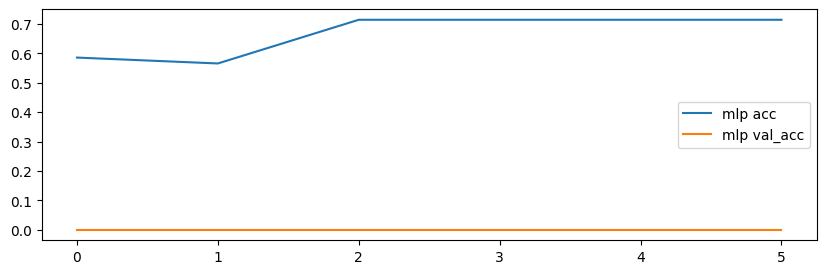

In [ ]:
# 선그래프 시각화
# acc, val_acc 출력
acc = mlp_his.history['accuracy']
val_acc = mlp_his.history['val_accuracy']

plt.figure(figsize=(10,3))
plt.plot(acc, label ='mlp acc')
plt.plot(val_acc, label='mlp val_acc')
plt.legend()
plt.show()

In [ ]:
# 모델 학습이 제대로 되지 않은 상황
# 복잡한 데이터, 모델 생각보다 단순했을 수 있음
# 개, 고양이에 대한 이미지 내부 특성을 잘 파악하지 못하는 것 같음
# 즉, 중요한 특성 파악이 안되서 성능이 안 좋은 상황
# mlp보다는 중요한 특성을 잘 파악하고(특성추출) 찾아내는 모델을 사용해보자 > CNN

#### CNN 모델 생성
  - 1. 모델 설계
    - 뼈대구축
    - 특성추출부(합성곱층): Conv, Pooling
    - 분류부(전결합층, 완전연결층, mlp)
  - 2. 컴파일
  - 3. 학습 및 시각화
  - 4. 예측 및 평가

In [7]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# f_ea 조기학습중단 연결

In [ ]:
# cnn 모델 설계
cnn_model = Sequential()
# 특성추출부
# cnn_model.add(Conv2D(필터개수, 필터크기, 입력특성크기, 패딩, 이동간격, 활성화함수))
cnn_model.add(Conv2D(filters=64, kernel_size=(3,3), input_shape=(224,224,3), padding='same', strides=(1,1), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2,2))) # 특정 지역 공간안에서 중요한 요소 다시 한번더 뽑아냄(추출, 걸러줌)
# mlp의 단점이었던 데이터 회전, 축소로 인한 변형 문제를 해결함
cnn_model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', strides=(1,1), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))
cnn_model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', strides=(1,1), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))

# 분류부
# 1차원으로 피기
cnn_model.add(Flatten()) # 입력의 크기 설정할 필요 없음
# 중간층 - cnn모델 특성상 conv층에서 특성 추출하고 연산 진행되기 때문에 분류부는 간단하게 층 설정
cnn_model.add(Dense(128, activation='relu'))
# 출력층 - 이진분류(개 vs 고양이)
cnn_model.add(Dense(1, activation='sigmoid'))

# 모델 요약
cnn_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 112, 112, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 56, 56, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 56, 56, 64)        73792     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 28, 28, 64)       

In [ ]:
# 컴파일
cnn_model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
# 학습 - 조기학습 중단
es = EarlyStopping(monitor='val_accuracy',
                   verbose=1,
                   patience=10)
cnn_model.fit(X_train, y_train, epochs=40,
              validation_split=0.3, batch_size=64,callbacks=[es])

Epoch 1/40
22/22 [==============================] - 18s 443ms/step - loss: 48.2625 - accuracy: 0.6400 - val_loss: 1.1913 - val_accuracy: 0.0000e+00
Epoch 2/40
22/22 [==============================] - 4s 164ms/step - loss: 0.6018 - accuracy: 0.7143 - val_loss: 1.0585 - val_accuracy: 0.0000e+00
Epoch 3/40
22/22 [==============================] - 4s 170ms/step - loss: 0.6019 - accuracy: 0.7143 - val_loss: 1.2295 - val_accuracy: 0.0000e+00
Epoch 4/40
22/22 [==============================] - 4s 178ms/step - loss: 0.5997 - accuracy: 0.7143 - val_loss: 1.2256 - val_accuracy: 0.0000e+00
Epoch 5/40
22/22 [==============================] - 4s 183ms/step - loss: 0.6018 - accuracy: 0.7143 - val_loss: 1.2048 - val_accuracy: 0.0000e+00
Epoch 6/40
22/22 [==============================] - 4s 178ms/step - loss: 0.6040 - accuracy: 0.7143 - val_loss: 1.0802 - val_accuracy: 0.0000e+00
Epoch 7/40
22/22 [==============================] - 4s 185ms/step - loss: 0.5982 - accuracy: 0.7143 - val_loss: 1.2661 - v

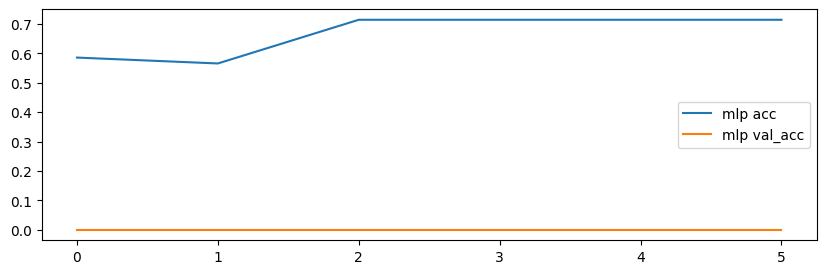

In [ ]:
# cnn_모델 acc, val_acc 시각화
plt.figure(figsize=(10,3))
plt.plot(acc, label ='mlp acc')
plt.plot(val_acc, label='mlp val_acc')
plt.legend()
plt.show()

In [ ]:
# mlp보다는 성능 개선이 되고 있는것 같음
# 여전히 과대적합인 상태
# 모델이 중요한 특성을 잘 찾고 있을 수 있지만,
# 데이터의 경우의 수가 부족해서 대상에 대한 학습이 미흡할 수 있음
# 변형되거나 약간씩 다른 데이터 형태를 더 확인시키면서 학습할 필요가 있음
# tensorflow 내부 이미지 증식 도구를 활용해서 진행해보자!

#### 이미지 증식(데이터 확장)을 통한 cnn성능 개선
  - tensorflow ImageDataGenerator 도구 활용
  - 이미지 증식을 위한 설정값을 이해해보기
  - 원본 이미지(사진) 형태를 그대로 사용(npz x)
  - 개고양이폴더/train, test 폴더 내부의 실제 이미지 경로를 연결해서 증식에 활용

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [9]:
# 증식할 데이터 경로를 변수에 저장
# 변형될 형식의 데이터 경우의 수를 정의 -> train 기준(학습할때, 일반화에 도움이 되는 데이터이기 때문에)
# 0~255 > 0~1 변환 -> train, test

train_gen = ImageDataGenerator(rescale=1/255,
                               zoom_range = 0.2, #확대/축소
                               horizontal_flip=True # 수평 뒤집기
                               )

# test 범위 변환
test_gen = ImageDataGenerator(rescale=1./255)
# test 데이터는 학습할 때 사용하지 않아서 확장 개념 연결 x

# 변형될 데이터 설정값을 실제 데이터와 연결
# train_generator = train_gen.flow_from_directory(경로, 데이터크기, 개수 제한,)
train_generator = train_gen.flow_from_directory('./data/cats_and_dogs_filtered/train', target_size=(224,224)
,batch_size = 10, class_mode='binary')

test_generator =test_gen.flow_from_directory('./data/cats_and_dogs_filtered/test', target_size=(224,224)
,batch_size = 10, class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [10]:
# 드롭아웃 - 랜덤하게 일정 비율만큼 퍼셉트론을 비활성화(규칙을 줄여주는 효과, 복잡성 제어)
from tensorflow.keras.layers import Dropout

In [13]:
# cnn 모델 설계
cnn_model2 = Sequential()
# 특성추출부
# cnn_model.add(Conv2D(필터개수, 필터크기, 입력특성크기, 패딩, 이동간격, 활성화함수))
cnn_model2.add(Conv2D(filters=64, kernel_size=(3,3), input_shape=(224,224,3), padding='same', strides=(1,1), activation='relu'))
cnn_model2.add(MaxPooling2D(pool_size=(2,2))) # 특정 지역 공간안에서 중요한 요소 다시 한번더 뽑아냄(추출, 걸러줌)
# mlp의 단점이었던 데이터 회전, 축소로 인한 변형 문제를 해결함
cnn_model2.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', strides=(1,1), activation='relu'))
cnn_model2.add(MaxPooling2D(pool_size=(2,2)))
cnn_model2.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', strides=(1,1), activation='relu'))
cnn_model2.add(MaxPooling2D(pool_size=(2,2)))

# 분류부
# 1차원으로 피기
cnn_model2.add(Flatten()) # 입력의 크기 설정할 필요 없음
# 중간층 - cnn모델 특성상 conv층에서 특성 추출하고 연산 진행되기 때문에 분류부는 간단하게 층 설정
cnn_model2.add(Dense(128, activation='relu'))
cnn_model2.add(Dropout(0.2)) # 20% 만큼 랜덤하게 퍼셉트론 비활성화
# 출력층 - 이진분류(개 vs 고양이)
cnn_model2.add(Dense(1, activation='sigmoid'))

# 모델 요약
cnn_model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 112, 112, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 56, 56, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 56, 56, 64)        73792     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 28, 28, 64)       

In [16]:
# 컴파일
cnn_model2.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

# 데이터 증식 도구가 알아서 c->d 순서로(알파벳 순서) 답 생성
cnn_his2 = cnn_model2.fit_generator(generator = train_generator,
                                    validation_data=test_generator,
                                    epochs=20)

<ipython-input-16-f53bbfd686cb>:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  cnn_his2 = cnn_model2.fit_generator(generator = train_generator,


Epoch 1/20
200/200 [==============================] - 993s 5s/step - loss: 0.7110 - accuracy: 0.4865 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/20
200/200 [==============================] - 43s 214ms/step - loss: 0.6932 - accuracy: 0.4790 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/20
200/200 [==============================] - 45s 227ms/step - loss: 0.6932 - accuracy: 0.4975 - val_loss: 0.6931 - val_accuracy: 0.5010
Epoch 4/20
200/200 [==============================] - 43s 217ms/step - loss: 0.6935 - accuracy: 0.4965 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 5/20
200/200 [==============================] - 42s 210ms/step - loss: 0.6933 - accuracy: 0.5015 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 6/20
200/200 [==============================] - 44s 222ms/step - loss: 0.6933 - accuracy: 0.5080 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 7/20
200/200 [==============================] - 42s 211ms/step - loss: 0.6933 - accuracy: 0.4845 - val_loss: 0.6931 - val_accu

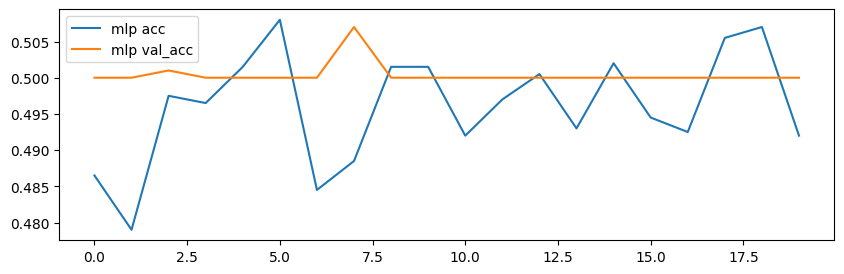

In [18]:
acc = cnn_his2.history['accuracy']
val_acc = cnn_his2.history['val_accuracy']

plt.figure(figsize=(10,3))
plt.plot(acc, label ='mlp acc')
plt.plot(val_acc, label='mlp val_acc')
plt.legend()
plt.show()

In [19]:
# 이미지 증식을 통해 나름대로 과대적합이 해소된 것을 알 수 있음
# 이미지 증식이 모델 성능 개선에 도움이 됨을 확인함
# 단점은 학습시간이 오래걸림
# 자체적으로 설계한 모델은 여러번 수정 후 검증이 필요함 > 시간이 오래걸림
# 전이학습: 학습 이미 진행한 모델의 가중치 값을 활용하여 새로운 데이터에 대해서 학습하거나 예측시키는 방법


#### 전이학습
  - 사전학습 모델(Pretrained model)을 사용해보자!
  - 학습을 빠르게 수행할 수 있음
  - 학습할 데이터에 대해 특징을 추출하는 학습이 필요없게 됨(시간단축)
  - 작은데이터셋에 대해서 학습할 때 과대적합 예방 가능
  - 완전히 똑같은 데이터로 학습x, 비슷한 분류 문제를 푼 모델을 활용함(레이블이 조금 다를 수 있음)
  - 분류할 대상은 다르지만, 판단하는 기준(w)는 비슷할 수 있어서 가져와서 활용하는 개념
    - 사전학습 모델: 사자 vs 호랑이 vs 코끼리
    - 현재 목표: 개 vs 고양이

In [34]:
# vgg16
from tensorflow.keras.applications import VGG16  # 전이학습 모델 여러종류가 있음!

In [35]:
# vgg: 특성 추출부만 가져오기
vgg_conv = VGG16(include_top = False,
                 input_shape=(224,224,3),
                 weights='imagenet')

vgg_conv.summary()

# 분류부(top)를 제외한 특성추출부를 vgg16모델의 것으로 활용함
# mlp층 클래스 2개 예측할 수 있게 생성하여 여녈할 예정
# +) 미세조정 필요할 시 적용 (conv 마지막 부분을 학습할 수 있게 설정하는 것)

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [36]:
# 컨볼루션 층 학습할 수 없게 설정
vgg_conv.trainable = False

In [39]:
# mlp층 클래스 2
# conv -> vgg 연결
# 전이학습(transfer learning)
transfer_model = Sequential()

# 특성 추출
transfer_model = Sequential() # 함수형 연결
# 분류부
transfer_model.add(Flatten())
transfer_model.add(Dense(64, activation='relu'))
transfer_model.add(Dense(1, activation='sigmoid'))

# 모델 정보 요약
#transfer_model.summary()

In [40]:
# 미세조정 방식
# 특성추출부의 끝부분 몇개 계층만 학습 가능하도록 연결하는 것
# 컨볼루션층들의 이름 확인
for layer in vgg_conv.layers:
  if layer.name == 'block5_conv3':
    layer.trainable = True
  else:
    # 나머지 층은 학습 불가능하게 가중치(W) 동결함
    layer.trainable = False

In [41]:
# npz 파일 데이터 활용해서 학습
transfer_model.compile(loss='binary_crossentropy',
                       optimizer = 'adam',
                       metrics = 'accuracy')

tf_his = transfer_model.fit(X_train, y_train,
                            validation_split = 0.3,
                            epochs=10)

Epoch 1/10
44/44 [==============================] - 2s 18ms/step - loss: 1173.7959 - accuracy: 0.6914 - val_loss: 0.7079 - val_accuracy: 0.0000e+00
Epoch 2/10
44/44 [==============================] - 0s 9ms/step - loss: 0.6835 - accuracy: 0.7143 - val_loss: 0.7255 - val_accuracy: 0.0000e+00
Epoch 3/10
44/44 [==============================] - 0s 10ms/step - loss: 0.6765 - accuracy: 0.7143 - val_loss: 0.7445 - val_accuracy: 0.0000e+00
Epoch 4/10
44/44 [==============================] - 0s 9ms/step - loss: 0.6697 - accuracy: 0.7143 - val_loss: 0.7635 - val_accuracy: 0.0000e+00
Epoch 5/10
44/44 [==============================] - 0s 9ms/step - loss: 0.6633 - accuracy: 0.7143 - val_loss: 0.7824 - val_accuracy: 0.0000e+00
Epoch 6/10
44/44 [==============================] - 0s 9ms/step - loss: 0.6573 - accuracy: 0.7143 - val_loss: 0.8016 - val_accuracy: 0.0000e+00
Epoch 7/10
44/44 [==============================] - 0s 11ms/step - loss: 0.6517 - accuracy: 0.7143 - val_loss: 0.8203 - val_accurac

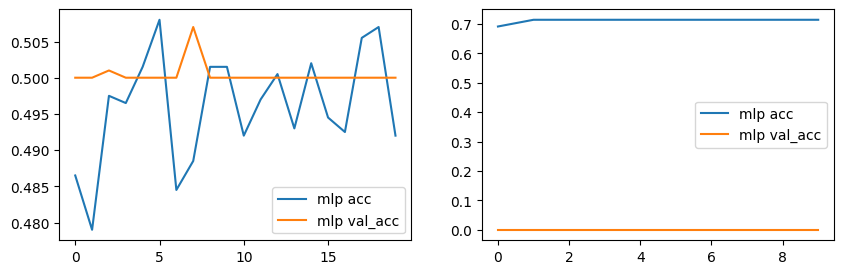

In [42]:
# 시각화 코드
# 이미지 증식이랑 비교
plt.figure(figsize=(10,3))

plt.subplot(1,2,1)
acc = cnn_his2.history['accuracy']
val_acc = cnn_his2.history['val_accuracy']

plt.plot(acc, label ='mlp acc')
plt.plot(val_acc, label='mlp val_acc')
plt.legend()

plt.subplot(1,2,2)    # 2번방에 그려줘
acc2 = tf_his.history['accuracy']
val_acc2 = tf_his.history['val_accuracy']

plt.plot(acc2, label ='mlp acc')
plt.plot(val_acc2, label='mlp val_acc')
plt.legend()

plt.show()

# 영상으로 다시 보는게 어떨까..